# David Kartchner
## CS 501 R
## Siamese ResNet

In [1]:
import numpy as np
import tensorflow as tf

## Load Image Data

In [2]:
from PIL import Image
import numpy as np
 
#
# assumes list.txt is a list of filenames, formatted as
#
# ./lfw2//Aaron_Eckhart/Aaron_Eckhart_0001.jpg
# ./lfw2//Aaron_Guiel/Aaron_Guiel_0001.jpg
# ...
#
 
files = open( './list.txt' ).readlines()
 
data = np.zeros(( len(files), 250, 250 ))
labels = np.zeros(( len(files), 1 ))
 
# a little hash map mapping subjects to IDs
ids = {}
scnt = 0
 
# load in all of our images
ind = 0
for fn in files:
 
    subject = fn.split('/')[2]
    if not ids.has_key( subject ):
        ids[ subject ] = scnt
        scnt += 1
    label = ids[ subject ]
 
    data[ ind, :, : ] = np.array( Image.open( fn.rstrip() ) )
    labels[ ind ] = label
    ind += 1
    
# data is (13233, 250, 250)
# labels is (13233, 1)
labels = labels.flatten()

In [8]:
# #classes, counts = np.unique(labels, return_counts=True)


# new_dat = data[:500,:,:]
# new_labs = labels[:500]

5748.0


## Make batch loader to load images

In [3]:
class BatchLoader(object):
    
    def __init__(self, data, labels, b_size=64):
        # Get unique classes for data
        ys, y_counts = np.unique(labels, return_counts=True)
        
        # Create batch size
        self.batch_size = b_size
        
        # Get dimensions of each image
        self.im_x, self.im_y = data.shape[1], data.shape[2]
        
        # Put 80% of people in train set and 20% in test set
        test_cutoff = int(.8*len(ys))
        
        # Create the following variables for train and test data:
            # class_counts: count of instances of each class
            # size: number of classes
            # multi_picture_classes: list of indices of classes with multiple pictures
            # people: list where each element is array of all pictures for a specific class
        print "Making Training Data"
        train_classes = ys[:test_cutoff]
        self.train_class_counts = y_counts[:test_cutoff]
        self.train_size = len(train_classes)
        self.train_multi_picture_classes = np.arange(self.train_size)[self.train_class_counts>1]
        self.train_people=[]
        for i in train_classes:
            self.train_people.append(data[labels==i])
        
        print "Making Test Data"
        test_classes = ys[test_cutoff:]
        self.test_class_counts = y_counts[test_cutoff:]
        self.test_size = len(test_classes)
        self.test_multi_picture_classes = np.arange(self.test_size)[self.test_class_counts>1]
        self.test_people=[]
        for i in test_classes:
            self.test_people.append(data[labels==i])
        
            
    
    def next_batch(self, train=True):
        # Get labels for whether images are same or different
        same_labels = np.random.binomial(1, .5, size=self.batch_size)
        
        #Create placeholder arrays for each list of images in the batch
        x1 = np.empty((self.batch_size, self.im_x, self.im_y))
        x2 = np.empty((self.batch_size, self.im_x, self.im_y))
        
        if train==True:
            multi_pic_classes = self.train_multi_picture_classes
            class_counts = self.train_class_counts
            people = self.train_people
            size = self.train_size
            
        else:
            multi_pic_classes = self.test_multi_picture_classes
            class_counts = self.test_class_counts
            people = self.test_people
            size = self.test_size
        
        for i, label in enumerate(same_labels):
            # If pictures are in the same class...
            if label:
                # Select a class with multiple instances
                cat = np.random.choice(multi_pic_classes)
                
                # Select two distinct elements from this class
                class_size = class_counts[cat]
                photo_indices = np.random.choice(class_size, size=2, replace=False)
                pics = people[cat][photo_indices,:,:]
                x1[i,:,:] = pics[0,:,:]
                x2[i,:,:] = pics[1,:,:]
                
            else:
                # Select pictures of two different people
                a,b = np.random.choice(size, size=2, replace=False)

                person1 = np.random.choice(class_counts[a])
                x1[i,:,:] = people[a][person1,:,:]
                
                person2 = np.random.choice(class_counts[b])
                x2[i,:,:] = people[b][person2,:,:]
                
                
        return x1, x2, same_labels

In [4]:
batch_loader = BatchLoader(data, labels)

Making Training Data
Making Test Data


## Make Resnet Architecture
### Start by defining useful helper functions

In [14]:
def conv2d( in_var, output_dim, name="conv2d" ):
    k_w = 7  # filter width/height
    k_h = 7
    d_h = 3  # x,y strides
    d_w = 3

    with tf.variable_scope( name ):
        W = tf.get_variable( "W", [k_h, k_w, in_var.get_shape()[-1], output_dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.02) )
        b = tf.get_variable( "b", [output_dim], initializer=tf.constant_initializer(0.01) )

        conv = tf.nn.conv2d( in_var, W, strides=[1, d_h, d_w, 1], padding='SAME' )
        conv = tf.reshape( tf.nn.bias_add( conv, b ), conv.get_shape() )

        return conv

    
def linear( in_var, output_size, name="linear", stddev=0.02, bias_val=.01 ):
    shape = in_var.get_shape().as_list()

    with tf.variable_scope( name ):
        W = tf.get_variable( "W", [shape[1], output_size], tf.float32,
                              tf.random_normal_initializer( stddev=stddev ) )
        b = tf.get_variable( "b", [output_size],
                             initializer=tf.constant_initializer( bias_val ))

        return tf.matmul( in_var, W ) + b    
    
    
    
def resnet_block(in_var, out_shape, stride=1, name='resnet'):
    """
    Make a ResNet layer, i.e. two convolutions and an identity mapping
    """
    k_w = 3 # Filter height
    k_h = 3 # Filter width
    x_stride = stride
    y_stride = stride
    
    if stride!=1 and stride!=2:
        print stride
        raise ValueError("Stride must be 1 or 2")
    
    with tf.variable_scope(name):
        # Weights and Biases for first layer
        w1 = tf.get_variable("W1", [k_w, k_h, in_var.get_shape()[-1], out_shape], 
                             initializer=tf.truncated_normal_initializer(stddev=.02))
        b1 = tf.get_variable('b1', [out_shape], initializer=tf.constant_initializer(.01))
        
        # Make first convolutional layer
        conv1 = tf.nn.conv2d(in_var, w1, strides=[1, x_stride, y_stride, 1], padding='SAME')
        conv1 = tf.reshape(tf.nn.bias_add(conv1, b1), conv1.get_shape())
        
        # Relu-fy the convolutional layer
        relu_layer = tf.nn.relu(conv1)
        
        # Weights and Biases for second layer
        w2 = tf.get_variable("W2", [k_w, k_h, relu_layer.get_shape()[-1], out_shape], 
                             initializer=tf.truncated_normal_initializer(stddev=.02))
        b2 = tf.get_variable('b2', [out_shape], initializer=tf.constant_initializer(.01))
        
        
        # Run another set of convolutions on output of relu
        conv2 = tf.nn.conv2d(relu_layer, w2, strides=[1, 1, 1, 1], padding='SAME')
        conv2 = tf.reshape(tf.nn.bias_add(conv2, b1), conv2.get_shape())
        
        if stride==1:
            ident= in_var
        else:
            w3 = tf.get_variable("W3", [1, 1, in_var.get_shape()[-1], out_shape], 
                             initializer=tf.truncated_normal_initializer(stddev=.02))
            in_var = tf.nn.conv2d(in_var, w3, strides=[1,1,1,1], padding="SAME")
            ident = tf.nn.max_pool(in_var, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
#             print in_var.get_shape()
        
        # Add identity and run through another relu
        add_x = tf.nn.relu(conv2 + ident)
    return add_x
        
        
def siamese_block(imgs):
    imgs = tf.reshape(imgs, [batch_size, x_dim, x_dim, 1])
    imgs = tf.nn.avg_pool(imgs,[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv0 = conv2d(imgs, 64, name='first_conv')
    res1 = resnet_block(conv0, 64, name='res1')
    res2 = resnet_block(res1, 64, name='res2')
    res3 = resnet_block(res2, 128, stride=2, name='res3')
    res4 = resnet_block(res3, 128, name='res4')
    res5 = resnet_block(res4, 256, stride=2, name='res5')
    pool1 = tf.reshape(tf.nn.max_pool(res5, [1,2,2,1], strides=[1,2,2,1], padding='SAME'), [batch_size,-1])
    fc_1 = linear(pool1, 1024, name='fc1')
    return fc_1

## Create baseline computation graph with 5 Resnet Blocks

In [15]:
tf.reset_default_graph()

#Create placeholder for input
x_dim = 250
batch_size = 64
margin = 4

# Create placeholder for inputs
x1 = tf.placeholder(tf.float32, [None, x_dim, x_dim], name='x1')
x2 = tf.placeholder(tf.float32, [None, x_dim, x_dim], name='x2')
y = tf.placeholder(tf.float32, [None], name='y')

#Create computation Graph
with tf.name_scope("Twin_1"):
    g1 = siamese_block(x1)
    
tf.get_variable_scope().reuse_variables()
with tf.name_scope("Twin_2"):
    g2 = siamese_block(x2)

with tf.name_scope("Energy"):
    energy = tf.reduce_mean((g1-g2)**2, reduction_indices=[1])
    
with tf.name_scope('Loss'):
    # Loss if pictures are in same class
    Lg = .5*(energy**2)
    
    # Loss if pictures are in different classes
    Li = .5*(tf.maximum(tf.zeros_like(energy), (margin*tf.ones_like(energy)-energy))**2)
    
    # Take weighted mean of above to get loss for a batch
    loss = tf.reduce_mean(y*Lg + (tf.ones_like(y)-y)*Li)
    
optim = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope("Accuracy"):
    # Create accuracy by classifying "match" (1) if energy < margin/2 and "not match" (0) otherwise
    accuracy = tf.reduce_mean( tf.cast(tf.equal( tf.cast((energy<(margin/2.)),tf.float32), y ), tf.float32) )

## Test of 5 Resnet Blocks

In [16]:
sess = tf.Session()
sess.run( tf.initialize_all_variables() )
summary_writer = tf.train.SummaryWriter( "./tf_logs", graph=sess.graph )

for i in range(500):
    batch_x1, batch_x2, batch_y = batch_loader.next_batch()

    sess.run(optim, feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})

    
    if i%10==0:
        acc_val, loss_val = sess.run([accuracy, loss], feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})
        print "%d\t Loss: %.2f  Accuracy: %.2f" % ( i, loss_val, acc_val )
        
        
batch_x1, batch_x2, batch_y = batch_loader.next_batch(train=False)
acc_val, loss_val = sess.run([accuracy, loss], feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})
print "Loss: %.2f  Accuracy: %.2f" % (loss_val, acc_val )


summary_writer.close()

0	 Loss: 2.34  Accuracy: 0.58
10	 Loss: 2.21  Accuracy: 0.66
20	 Loss: 1.76  Accuracy: 0.61
30	 Loss: 1.73  Accuracy: 0.58
40	 Loss: 1.92  Accuracy: 0.56
50	 Loss: 1.76  Accuracy: 0.66
60	 Loss: 1.49  Accuracy: 0.73
70	 Loss: 1.60  Accuracy: 0.78
80	 Loss: 1.35  Accuracy: 0.80
90	 Loss: 1.63  Accuracy: 0.69
100	 Loss: 1.28  Accuracy: 0.75
110	 Loss: 1.36  Accuracy: 0.75
120	 Loss: 1.40  Accuracy: 0.75
130	 Loss: 1.10  Accuracy: 0.78
140	 Loss: 1.32  Accuracy: 0.80
150	 Loss: 1.45  Accuracy: 0.72
160	 Loss: 1.49  Accuracy: 0.73
170	 Loss: 1.36  Accuracy: 0.77
180	 Loss: 1.24  Accuracy: 0.75
190	 Loss: 1.00  Accuracy: 0.84
200	 Loss: 1.29  Accuracy: 0.77
210	 Loss: 1.15  Accuracy: 0.81
220	 Loss: 1.30  Accuracy: 0.78
230	 Loss: 1.35  Accuracy: 0.73
240	 Loss: 1.26  Accuracy: 0.77
250	 Loss: 1.29  Accuracy: 0.77
260	 Loss: 1.08  Accuracy: 0.86
270	 Loss: 1.14  Accuracy: 0.86
280	 Loss: 0.99  Accuracy: 0.86
290	 Loss: 0.95  Accuracy: 0.86
300	 Loss: 1.29  Accuracy: 0.78
310	 Loss: 1.07  Ac

#### Test accuracy of 5 block resnet

In [ ]:
loss_5_block = []
acc_5_block = []
for i in xrange(10):
    batch_x1, batch_x2, batch_y = batch_loader.next_batch(train=False)
    acc_val, loss_val = sess.run([accuracy, loss], feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})
    
#     print "Loss: %.2f  Accuracy: %.2f" % (loss_val, acc_val )
    loss_5_block.append(loss_val)
    acc_5_block.append(acc_val)

In [21]:
print "Average Loss:", np.mean(loss_5_block)
print "Average Accuracy:", np.mean(acc_5_block)

Average Loss: 1.59789
Average Accuracy: 0.735937


## Test of 7 Resnet Blocks

In [18]:
def siamese_block(imgs):
    imgs = tf.reshape(imgs, [batch_size, x_dim, x_dim, 1])
    imgs = tf.nn.avg_pool(imgs,[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv0 = conv2d(imgs, 64, name='first_conv')
    res1 = resnet_block(conv0, 64, name='res1')
    res2 = resnet_block(res1, 64, name='res2')
    res3 = resnet_block(res2, 128, stride=2, name='res3')
    res4 = resnet_block(res3, 128, name='res4')
    res5 = resnet_block(res4, 256, stride=2, name='res5')
    res6 = resnet_block(res5, 256, name='res6')
    res7 = resnet_block(res6, 512, stride=2, name='res7')
    
    pool1 = tf.reshape(tf.nn.max_pool(res7, [1,2,2,1], strides=[1,2,2,1], padding='SAME'), [batch_size,-1])
    fc_1 = linear(pool1, 1024, name='fc1')
    return fc_1

tf.reset_default_graph()

#Create placeholder for input
x_dim = 250
batch_size = 64
margin = 4

# Create placeholder for inputs
x1 = tf.placeholder(tf.float32, [None, x_dim, x_dim], name='x1')
x2 = tf.placeholder(tf.float32, [None, x_dim, x_dim], name='x2')
y = tf.placeholder(tf.float32, [None], name='y')

#Create computation Graph
with tf.name_scope("Twin_1"):
    g1 = siamese_block(x1)
    
tf.get_variable_scope().reuse_variables()
with tf.name_scope("Twin_2"):
    g2 = siamese_block(x2)

with tf.name_scope("Energy"):
    energy = tf.reduce_mean((g1-g2)**2, reduction_indices=[1])
    
with tf.name_scope('Loss'):
    # Loss if pictures are in same class
    Lg = .5*(energy**2)
    
    # Loss if pictures are in different classes
    Li = .5*(tf.maximum(tf.zeros_like(energy), (margin*tf.ones_like(energy)-energy))**2)
    
    # Take weighted mean of above to get loss for a batch
    loss = tf.reduce_mean(y*Lg + (tf.ones_like(y)-y)*Li)
    
optim = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope("Accuracy"):
    # Create accuracy by classifying "match" (1) if energy < margin/2 and "not match" (0) otherwise
    accuracy = tf.reduce_mean( tf.cast(tf.equal( tf.cast((energy<(margin/2.)),tf.float32), y ), tf.float32) )
    
sess = tf.Session()
sess.run( tf.initialize_all_variables() )
summary_writer = tf.train.SummaryWriter( "./tf_logs", graph=sess.graph )

for i in range(500):
    batch_x1, batch_x2, batch_y = batch_loader.next_batch()

    sess.run(optim, feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})

    
    if i%10==0:
        acc_val, loss_val = sess.run([accuracy, loss], feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})
        print "%d\t Loss: %.2f  Accuracy: %.2f" % ( i, loss_val, acc_val )
        
        



summary_writer.close()

0	 Loss: 3.81  Accuracy: 0.44
10	 Loss: 3.28  Accuracy: 0.56
20	 Loss: 2.32  Accuracy: 0.58
30	 Loss: 2.33  Accuracy: 0.64
40	 Loss: 2.64  Accuracy: 0.58
50	 Loss: 2.40  Accuracy: 0.48
60	 Loss: 1.90  Accuracy: 0.59
70	 Loss: 1.99  Accuracy: 0.53
80	 Loss: 1.71  Accuracy: 0.66
90	 Loss: 1.74  Accuracy: 0.64
100	 Loss: 1.41  Accuracy: 0.73
110	 Loss: 1.37  Accuracy: 0.73
120	 Loss: 1.66  Accuracy: 0.69
130	 Loss: 1.33  Accuracy: 0.80
140	 Loss: 1.58  Accuracy: 0.73
150	 Loss: 1.60  Accuracy: 0.62
160	 Loss: 1.57  Accuracy: 0.69
170	 Loss: 1.45  Accuracy: 0.75
180	 Loss: 1.47  Accuracy: 0.73
190	 Loss: 1.70  Accuracy: 0.64
200	 Loss: 1.65  Accuracy: 0.70
210	 Loss: 1.53  Accuracy: 0.67
220	 Loss: 1.73  Accuracy: 0.69
230	 Loss: 1.52  Accuracy: 0.72
240	 Loss: 1.50  Accuracy: 0.73
250	 Loss: 1.47  Accuracy: 0.66
260	 Loss: 1.13  Accuracy: 0.84
270	 Loss: 1.63  Accuracy: 0.67
280	 Loss: 1.22  Accuracy: 0.80
290	 Loss: 1.01  Accuracy: 0.84
300	 Loss: 1.40  Accuracy: 0.72
310	 Loss: 1.40  Ac

#### Test accuracy of 7 block siamese net

In [22]:
loss_7_block = []
acc_7_block = []
for i in xrange(10):
    batch_x1, batch_x2, batch_y = batch_loader.next_batch(train=False)
    acc_val, loss_val = sess.run([accuracy, loss], feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})
    
#     print "Loss: %.2f  Accuracy: %.2f" % (loss_val, acc_val )
    loss_7_block.append(loss_val)
    acc_7_block.append(acc_val)
print "Average Loss:", np.mean(loss_7_block)
print "Average Accuracy:", np.mean(acc_7_block)

Average Loss: 1.63687
Average Accuracy: 0.717188


## Test of 3 Resnet Blocks 

In [10]:
def siamese_block(imgs):
    imgs = tf.reshape(imgs, [batch_size, x_dim, x_dim, 1])
    imgs = tf.nn.avg_pool(imgs,[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv0 = conv2d(imgs, 64, name='first_conv')
    res1 = resnet_block(conv0, 64, name='res1')
    res2 = resnet_block(res1, 64, name='res2')
    res3 = resnet_block(res2, 128, stride=2, name='res3')
    
    pool1 = tf.reshape(tf.nn.max_pool(res3, [1,2,2,1], strides=[1,2,2,1], padding='SAME'), [batch_size,-1])
    fc_1 = linear(pool1, 1024, name='fc1')
    return fc_1

tf.reset_default_graph()

#Create placeholder for input
x_dim = 250
batch_size = 64
margin = 4

# Create placeholder for inputs
x1 = tf.placeholder(tf.float32, [None, x_dim, x_dim], name='x1')
x2 = tf.placeholder(tf.float32, [None, x_dim, x_dim], name='x2')
y = tf.placeholder(tf.float32, [None], name='y')

#Create computation Graph
with tf.name_scope("Twin_1"):
    g1 = siamese_block(x1)
    
tf.get_variable_scope().reuse_variables()
with tf.name_scope("Twin_2"):
    g2 = siamese_block(x2)

with tf.name_scope("Energy"):
    energy = tf.reduce_mean((g1-g2)**2, reduction_indices=[1])
    
with tf.name_scope('Loss'):
    # Loss if pictures are in same class
    Lg = .5*(energy**2)
    
    # Loss if pictures are in different classes
    Li = .5*(tf.maximum(tf.zeros_like(energy), (margin*tf.ones_like(energy)-energy))**2)
    
    # Take weighted mean of above to get loss for a batch
    loss = tf.reduce_mean(y*Lg + (tf.ones_like(y)-y)*Li)
    
optim = tf.train.AdamOptimizer(1e-4).minimize(loss)

with tf.name_scope("Accuracy"):
    # Create accuracy by classifying "match" (1) if energy < margin/2 and "not match" (0) otherwise
    accuracy = tf.reduce_mean( tf.cast(tf.equal( tf.cast((energy<(margin/2.)),tf.float32), y ), tf.float32) )
    
sess = tf.Session()
sess.run( tf.initialize_all_variables() )
summary_writer = tf.train.SummaryWriter( "./tf_logs", graph=sess.graph )

for i in range(500):
    batch_x1, batch_x2, batch_y = batch_loader.next_batch()

    sess.run(optim, feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})

    
    if i%10==0:
        acc_val, loss_val = sess.run([accuracy, loss], feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})
        print "%d\t Loss: %.2f  Accuracy: %.2f" % ( i, loss_val, acc_val )
        
        



summary_writer.close()

0
0	 Loss: 18.18  Accuracy: 0.56
1
2
3
4
5
6
7
8
9
10
10	 Loss: 2.00  Accuracy: 0.56
11
12
13
14
15
16
17
18
19
20
20	 Loss: 2.10  Accuracy: 0.50
21
22
23
24
25
26
27
28
29
30
30	 Loss: 2.06  Accuracy: 0.59
31
32
33
34
35
36
37
38
39
40
40	 Loss: 1.82  Accuracy: 0.69
41
42
43
44
45
46
47
48
49
50
50	 Loss: 1.95  Accuracy: 0.56
51
52
53
54
55
56
57
58
59
60
60	 Loss: 1.89  Accuracy: 0.66
61
62
63
64
65
66
67
68
69
70
70	 Loss: 1.89  Accuracy: 0.55
71
72
73
74
75
76
77
78
79
80
80	 Loss: 1.69  Accuracy: 0.69
81
82
83
84
85
86
87
88
89
90
90	 Loss: 2.14  Accuracy: 0.50
91
92
93
94
95
96
97
98
99
100
100	 Loss: 1.58  Accuracy: 0.73
101
102
103
104
105
106
107
108
109
110
110	 Loss: 1.47  Accuracy: 0.80
111
112
113
114
115
116
117
118
119
120
120	 Loss: 1.67  Accuracy: 0.66
121
122
123
124
125
126
127
128
129
130
130	 Loss: 1.67  Accuracy: 0.66
131
132
133
134
135
136
137
138
139
140
140	 Loss: 1.45  Accuracy: 0.77
141
142
143
144
145
146
147
148
149
150
150	 Loss: 1.61  Accuracy: 0.70
151


#### Test accuracy of 3 block siamese net

In [13]:
loss_3_block = []
acc_3_block = []
for i in xrange(10):
    batch_x1, batch_x2, batch_y = batch_loader.next_batch(train=False)
    acc_val, loss_val = sess.run([accuracy, loss], feed_dict={x1:batch_x1, x2:batch_x2, y:batch_y})
    
#     print "Loss: %.2f  Accuracy: %.2f" % (loss_val, acc_val )
    loss_3_block.append(loss_val)
    acc_3_block.append(acc_val)
print "Average Loss:", np.mean(loss_3_block)
print "Average Accuracy:", np.mean(acc_3_block)

Average Loss: 1.57183
Average Accuracy: 0.721875


## Screenshot of Tensorboard

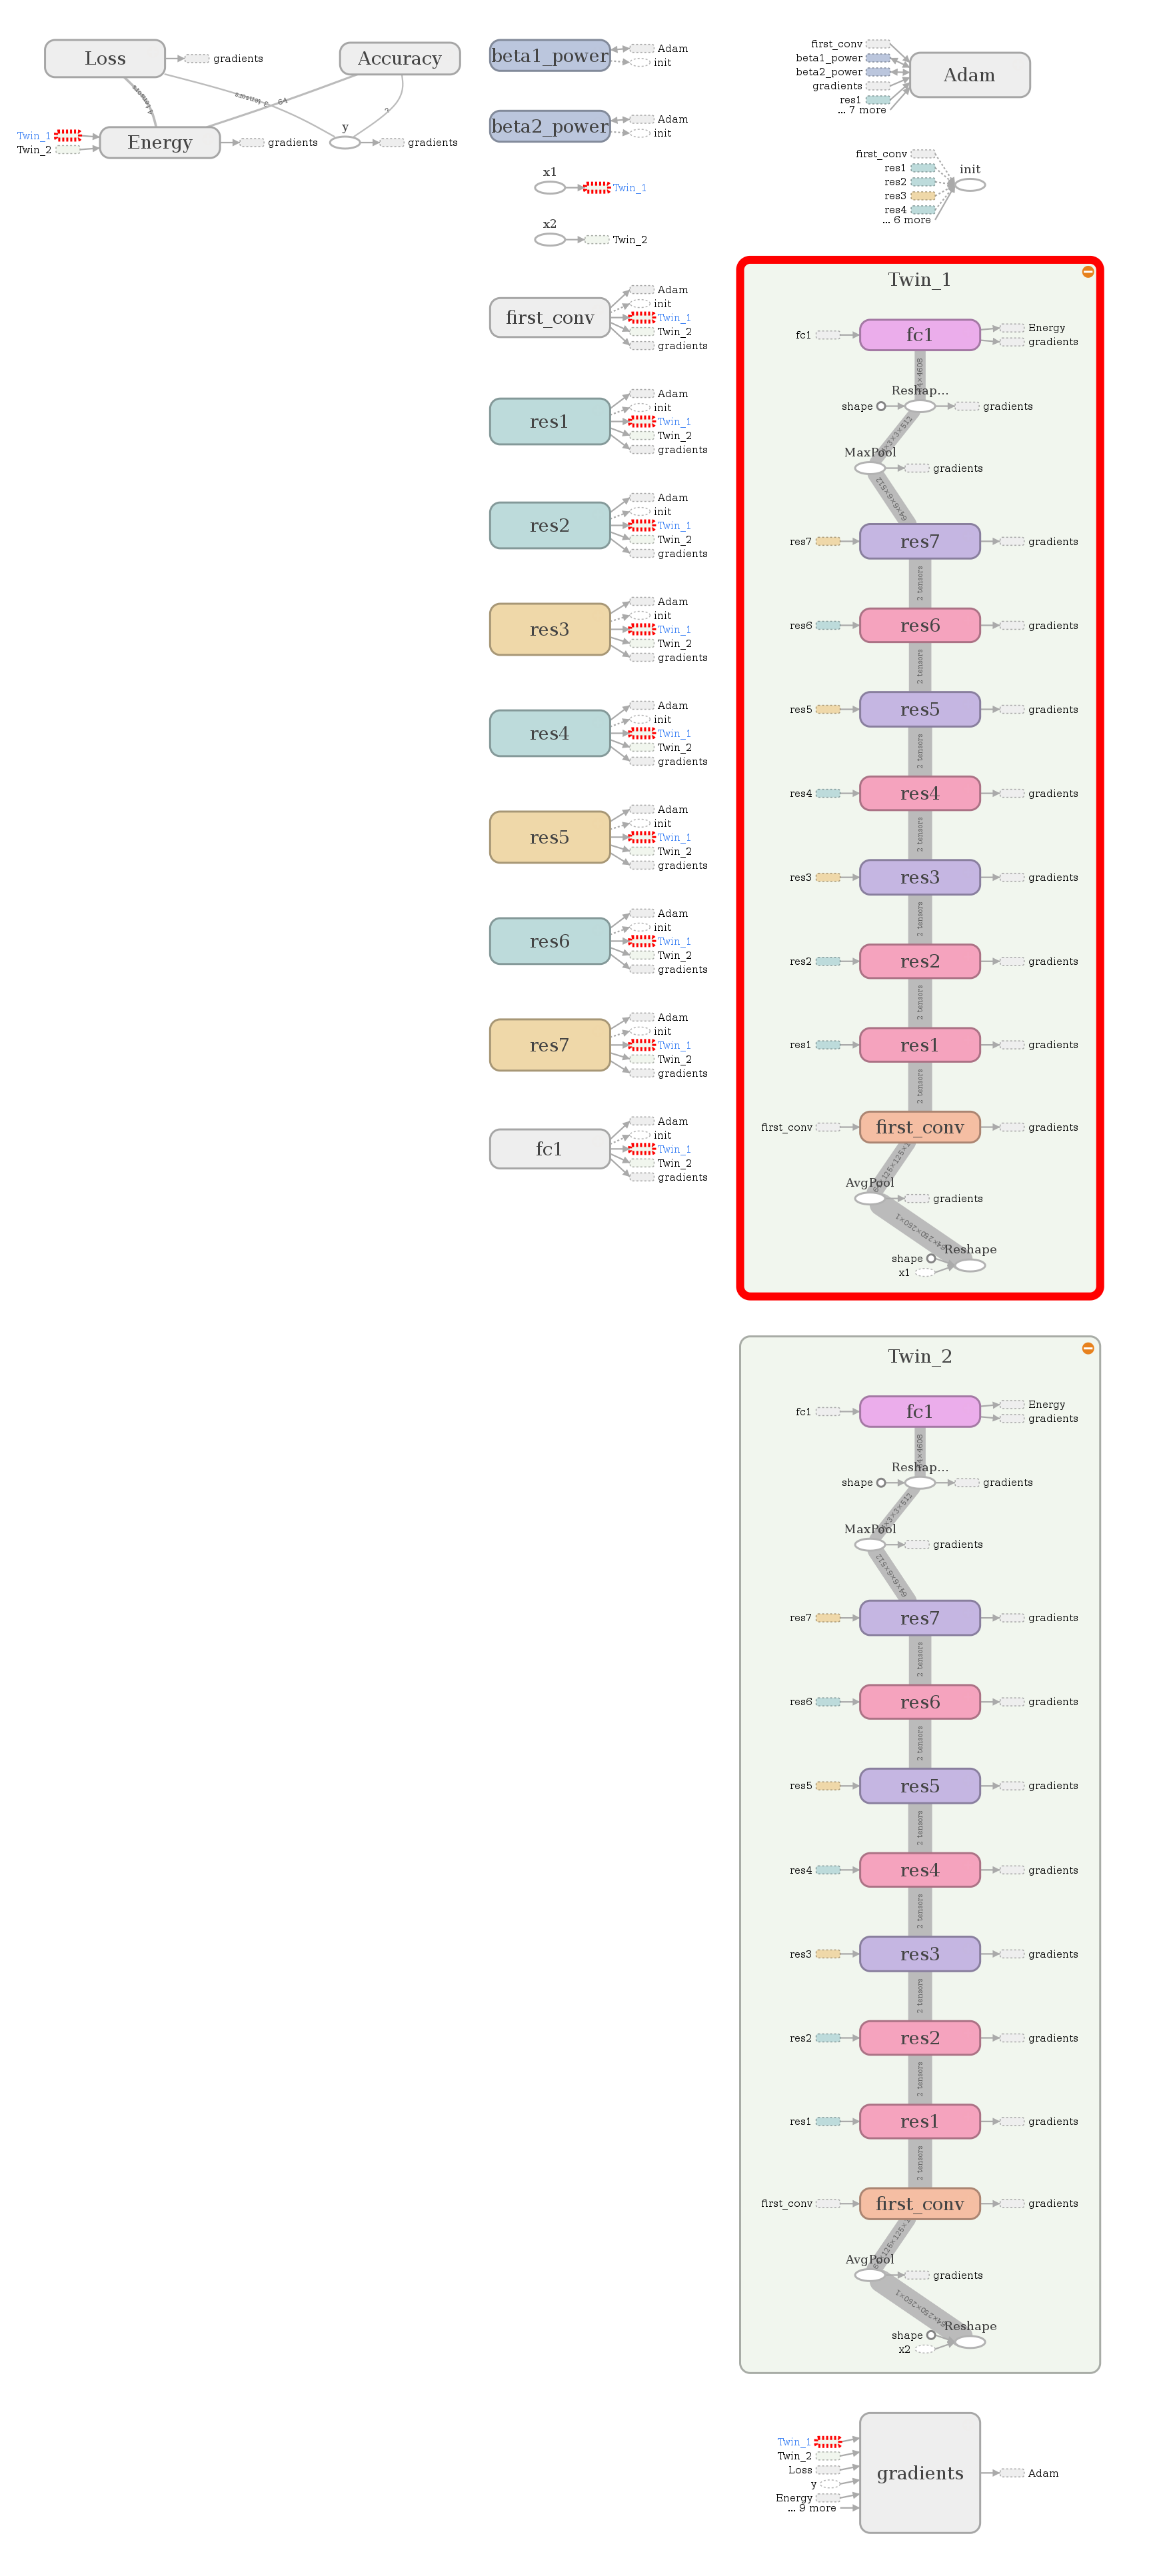

In [1]:
from IPython.display import Image
Image(filename='Siamese Tensorboard.png')

## Writeup


1.	Data Preprocessing  
a)	I split my data into 80% training data and 20% test data, as per normal industry practice in my past machine learning internships.  
b)	To pass images to my network, I created a batch loader that randomly chose pairs of images that were either from the same class or different classes based on draws from a Bernoulli random variable with p=0.5.  The batch loader then returned two arrays of images and an array of ones and zeros indicating whether or not the images were from the same class.  
2.	ResNet Architecture  
a)	To add resnet layers to my network, I created a function that performs two 3x3 convolutions on the inputs (the two convolutional layers are separated by a relu).  I then added the identity (reshaping as necessary with a 1x1 convolution, as described in the ResNet paper), then put the final output through a relu before mapping to the next layer.  When I doubled the “depth” of a block (by doubling the number of convolutional filters), I shrunk the image dimensions by ¼ by using 2x2 max pooling with x and y strides of 2.  
3.	Network Architecture  
a)	To keep my network from running out of RAM, I performed a 2x2 average pooling to shrink the images to ¼ of their original size.  I then ran them through a 7x7 convolution to extract larger features and further shrink the images, following which I tested varying numbers of resnet blocks (incrementally increasing in depth) to optimize the accuracy of my network.  I tried 3, 5, and 7 blocks and found that a deeper structure did little to improve accuracy over the 500 iterations for which I ran my net.  Moreover, I noticed that accuracy leveled off after a few hundred iterations, suggesting the need to drop the learning rate part way through the training.  
b)	For a loss function, I used a contrastive loss function, as described in the Siamese network slides, modified slightly to fit the way I labeled my pairs of images.  I began using a margin of 4 as a guess, but discovered that this happened to be remarkably close to the average energy for each image.  I decided to keep this margin, as doing so lead to good network performance.  
c.	To calculate accuracy, I simply classified all image pairs with energy < margin/2 as “same” and all pairs with energy >= margin/2 as “different.”  This accuracy steadily improved as I trained my network, as expected.
4.	Results:  
a)	3 resnet blocks:    
    i.	Final Loss: 1.57  
    ii.	Final Accuracy: 72.2%  
b)	5 resnet blocks:    
    i.	Final Loss: 1.60  
    ii.	Final Accuracy: 73.5%  
c)	7 resnet blocks:  
    i.	Final Loss: 1.64  
    ii.	Final Accuracy: 71.7%   
